# Import Libraries

In [ ]:
import numpy as np
import pandas as pd
import nltk
nltk.download('stopwords')
nltk.download('wordnet')
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
!pip install contractions
import contractions
import re
import tensorflow as tf
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
from sklearn.metrics import precision_recall_fscore_support
import statistics

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
     |████████████████████████████████| 321 kB 11.9 MB/s 
     |████████████████████████████████| 284 kB 44.9 MB/s 
  Created wheel for pyahocorasick: filename=pyahocorasick-1.4.2-cp37-cp37m-linux_x86_64.whl size=85454 sha256=7e33a7bf19f6152cee03f55e893ba3556373da4997b04fbdaf49603269df1cdd
  Stored in directory: /root/.cache/pip/wheels/25/19/a6/8f363d9939162782bb8439d886469756271abc01f76fbd790f
Successfully built pyahocorasick


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
train_data = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Data/train_clean.csv')
val_data = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Data/val_clean.csv')
test_data = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Data/test_clean.csv')
val_data.head()

,Clean_text,admiration,amusement,anger,annoyance,approval,caring,confusion,curiosity,desire,disappointment,disapproval,disgust,embarrassment,excitement,fear,gratitude,grief,joy,love,nervousness,optimism,pride,realization,relief,remorse,sadness,surprise,neutral
0,is this in new orleans ?? i really feel like t...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
1,you know the answer man you are programmed to ...,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
2,i have never been this sad in my life !,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
3,the economy is heavily controlled and subsidiz...,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
4,he could have easily taken a real camera from ...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0


**Check for null values in train, val and test dataset**

In [ ]:
# Check for null values in train, val and test dataset
data = {'Train Data': train_data, 'Validation Data': val_data, 'Test Data': test_data}
for temp in data:
    print(temp)
    print(data[temp].isnull().sum())
    print('*'*20)

Train Data
Clean_text        14
admiration         0
amusement          0
anger              0
annoyance          0
approval           0
caring             0
confusion          0
curiosity          0
desire             0
disappointment     0
disapproval        0
disgust            0
embarrassment      0
excitement         0
fear               0
gratitude          0
grief              0
joy                0
love               0
nervousness        0
optimism           0
pride              0
realization        0
relief             0
remorse            0
sadness            0
surprise           0
neutral            0
dtype: int64
********************
Validation Data
Clean_text        1
admiration        0
amusement         0
anger             0
annoyance         0
approval          0
caring            0
confusion         0
curiosity         0
desire            0
disappointment    0
disapproval       0
disgust           0
embarrassment     0
excitement        0
fear              0
gratitude 

In [ ]:
# eliminate null value
train_data = train_data[ ~(train_data.Clean_text.isnull()) ]
train_data = train_data.reset_index(drop=True)

val_data = val_data[ ~(val_data.Clean_text.isnull()) ]
val_data = val_data.reset_index(drop=True)

test_data = test_data[ ~(test_data.Clean_text.isnull()) ]
test_data = test_data.reset_index(drop=True)

In [ ]:
# Loading emotion labels
with open("/content/drive/MyDrive/Colab Notebooks/Data/emotions.txt", "r") as file:
  Lable_names = file.read().split("\n")

In [ ]:
# Creating train, validation and test variables
y_train = train_data.loc[:, Lable_names].values.astype(float)
y_val = val_data.loc[:, Lable_names].values.astype(float)
y_test = test_data.loc[:, Lable_names].values.astype(float)

# Encoding

There is a very helpful function called encode_plus provided in the Tokenizer class. It can seamlessly perform the following operations:

* Tokenize the text and Add special tokens - [CLS] and [SEP]
* create input IDs
* Pad the sentences to a maximum length
* Create attention masks for the above PAD tokens

 RoBERTa uses byte-level Byte-Pair Encoding (BPE) in contrast to BERT’s character-level BPE.

In [ ]:
!pip install transformers

     |████████████████████████████████| 3.5 MB 10.0 MB/s 
     |████████████████████████████████| 67 kB 3.0 MB/s 
     |████████████████████████████████| 6.8 MB 37.6 MB/s 
     |████████████████████████████████| 596 kB 40.4 MB/s 
     |████████████████████████████████| 895 kB 38.5 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [ ]:
from transformers import RobertaTokenizerFast
tokenizer = RobertaTokenizerFast.from_pretrained("roberta-base")

Downloading:   0%|          | 0.00/878k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/446k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.29M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/481 [00:00<?, ?B/s]

In [ ]:
def roberta_encode(data,maximum_length) :
  input_ids = []
  attention_masks = []
  for i in range(len(data.Clean_text)):
      encoded = tokenizer.encode_plus(data.Clean_text[i],
                                      add_special_tokens=True,
                                      max_length=maximum_length,
                                      pad_to_max_length=True,
                                      return_attention_mask=True,)
      input_ids.append(encoded['input_ids'])
      attention_masks.append(encoded['attention_mask'])
  return np.array(input_ids),np.array(attention_masks)

In [ ]:
#train_data['content_no_punctuation'] = train_data['content_no_punctuation'].str.count(' ')
train_data['Clean_text'].describe()

count         43396
unique        42977
top       thank you
freq             19
Name: Clean_text, dtype: object

In [ ]:
max_len = max([len(x.split()) for x in train_data['Clean_text']])
# max_len = 15
train_input_ids,train_attention_masks = roberta_encode(train_data,max_len)
test_input_ids,test_attention_masks = roberta_encode(test_data,max_len)
val_input_ids,val_attention_masks = roberta_encode(val_data,max_len)

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2257: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


In [ ]:
max_len

48

In [ ]:
pd.options.display.max_colwidth = 500
train_data.iloc[80]

Clean_text        oh forgive u for trying to make an exciting atmosphere at our homecourt
admiration                                                                              0
amusement                                                                               0
anger                                                                                   0
annoyance                                                                               0
approval                                                                                0
caring                                                                                  0
confusion                                                                               0
curiosity                                                                               0
desire                                                                                  0
disappointment                                                                          0
disapprova

# **Making an attention layer**

In [ ]:
class Attention(tf.keras.Model):
    def __init__(self, units):
        super(Attention, self).__init__()
        self.W1 = tf.keras.layers.Dense(units)
        self.W2 = tf.keras.layers.Dense(units)
        self.V = tf.keras.layers.Dense(1)

    def call(self, features, hidden):
        # hidden shape == (batch_size, hidden size)
        # hidden_with_time_axis shape == (batch_size, 1, hidden size)
        # we are doing this to perform addition to calculate the score
        hidden_with_time_axis = tf.expand_dims(hidden, 1)

        # score shape == (batch_size, max_length, 1)
        # we get 1 at the last axis because we are applying score to self.V
        # the shape of the tensor before applying self.V is (batch_size, max_length, units)
        score = tf.nn.tanh(self.W1(features) + self.W2(hidden_with_time_axis))
        # attention_weights shape == (batch_size, max_length, 1)
        attention_weights = tf.nn.softmax(self.V(score), axis=1)

        # context_vector shape after sum == (batch_size, hidden_size)
        context_vector = attention_weights * features
        context_vector = tf.reduce_sum(context_vector, axis=1)
        return context_vector, attention_weights

# **Making an self attention layer**

In [ ]:
# pip install keras-self-attention

In [ ]:
# from keras_self_attention import SeqSelfAttention

# Create Model

**How RoBERTa is better than BERT ??**

Changes in Pre-Training:
* without NSP objective
* with dynamic mask generation

Changes in Data:
* Trained on more data (16GB BERT vs 160GB RoBERTa)
* Trained on large batches



In [ ]:
from tensorflow.keras import Model, Input
from tensorflow.keras.layers import LSTM, Embedding, Dense , Concatenate , Flatten
from tensorflow.keras.layers import TimeDistributed, SpatialDropout1D, Bidirectional

In [ ]:
from keras.layers import Dropout

In [ ]:
from sklearn.utils.class_weight import compute_class_weight
from keras import backend as K

In [ ]:
# Function for calculating multilabel class weights
def calculating_class_weights(y_true):
    number_dim = np.shape(y_true)[1]
    weights = np.empty([number_dim, 2])
    for i in range(number_dim):
        weights[i] = compute_class_weight(class_weight='balanced', classes=[0.,1.], y=y_true[:, i])   # n_samples / (n_classes * np.bincount(y))
    return weights

class_weights = calculating_class_weights(y_train)


# Custom loss function for multilabel
def get_weighted_loss(weights):
    def weighted_loss(y_true, y_pred):
        return K.mean((weights[:,0]**(1-y_true))*(weights[:,1]**(y_true))*K.binary_crossentropy(y_true, y_pred), axis=-1)
    return weighted_loss


# Set loss
loss = get_weighted_loss(class_weights)

In [ ]:
class_weights

array([[  0.55259003,   5.25375303],
       [  0.52833037,   9.32445208],
       [  0.51873102,  13.8468411 ],
       [  0.53017642,   8.78461538],
       [  0.53632252,   7.38278326],
       [  0.51284597,  19.96136155],
       [  0.51627486,  15.86111111],
       [  0.52658658,   9.90324053],
       [  0.5074962 ,  33.85023401],
       [  0.5150616 ,  17.09850276],
       [  0.52443564,  10.73095945],
       [  0.5092949 ,  27.39646465],
       [  0.50351565,  71.61056106],
       [  0.51002515,  25.43728019],
       [  0.50696262,  36.40604027],
       [  0.53267541,   8.15101427],
       [  0.50088876, 281.79220779],
       [  0.51730879,  14.94352617],
       [  0.52524812,  10.40172579],
       [  0.50189674, 132.30487805],
       [  0.5189047 ,  13.72422517],
       [  0.5012822 , 195.47747748],
       [  0.51312491,  19.54774775],
       [  0.50176907, 141.81699346],
       [  0.50635924,  39.81284404],
       [  0.51575945,  16.36349925],
       [  0.5125189 ,  20.46981132],
 

In [ ]:
a = [0,0,0,1,0,1]
np.bincount(a)

array([4, 2])

In [ ]:
y_train[:,0].shape

(43396,)

In [ ]:
K.binary_crossentropy([1. , 0.], [0.8 , 0.5])

<tf.Tensor: shape=(2,), dtype=float32, numpy=array([0.22314338, 0.69314694], dtype=float32)>

In [ ]:
!pip install keras-self-attention
import keras
from keras_self_attention import SeqSelfAttention

  Created wheel for keras-self-attention: filename=keras_self_attention-0.51.0-py3-none-any.whl size=18912 sha256=c0c7b238bc2de931e8317fd0a542408f5fb390c995488ae3a7471c85fd23f4fe
  Stored in directory: /root/.cache/pip/wheels/95/b1/a8/5ee00cc137940b2f6fa198212e8f45d813d0e0d9c3a04035a3
Successfully built keras-self-attention


In [ ]:
from transformers import TFRobertaModel
roberta_model = TFRobertaModel.from_pretrained('roberta-base')

Downloading:   0%|          | 0.00/627M [00:00<?, ?B/s]

Some layers from the model checkpoint at roberta-base were not used when initializing TFRobertaModel: ['lm_head']
- This IS expected if you are initializing TFRobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFRobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFRobertaModel were initialized from the model checkpoint at roberta-base.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFRobertaModel for predictions without further training.


In [ ]:
def create_model(bert_model, max_len):
    input_ids = tf.keras.Input(shape=(max_len,),dtype='int32')
    attention_masks = tf.keras.Input(shape=(max_len,),dtype='int32')

    output = bert_model([input_ids,attention_masks])

    output = output[0]

    # output = output[1]  ERROR

    # print(len(output[0]))
    # print(output[0].shape)
    # print(output[1].shape)

    # output = SeqSelfAttention(
    #                           attention_activation='softmax'
                              # attention_type=SeqSelfAttention.ATTENTION_TYPE_MUL,
                              # attention_activation=None,
                              # kernel_regularizer=keras.regularizers.l2(1e-6),
                              # use_attention_bias=False
                              # )(output)

    # output = tf.expand_dims(output, axis=1)





    # l_cov1= Conv1D(128, 5, activation='relu')(output)
    # l_pool1 = MaxPooling1D(5)(l_cov1)
    # l_cov2 = Conv1D(128, 5, activation='relu')(l_pool1)
    # l_pool2 = MaxPooling1D(5)(l_cov2)
    # l_cov3 = Conv1D(128, 5, activation='relu')(l_pool2)
    # l_pool3 = MaxPooling1D(35)(l_cov3)  # global max pooling
    # l_flat = Flatten()(l_pool3)
    # l_dense = Dense(128, activation='relu')(l_flat)
    # output = Dense(28, activation='softmax')(l_dense)






    (lstm, forward_h, forward_c, backward_h, backward_c) = Bidirectional(LSTM(units=100,
                                                                            return_sequences=True,
                                                                            return_state=True,
                                                                            recurrent_dropout=0.1))(output)
    state_h = Concatenate()([forward_h, backward_h])
    state_c = Concatenate()([forward_c, backward_c])

    # print(state_h.shape)

    context_vector, attention_weights = Attention(30)(lstm, state_h)

    output = tf.keras.layers.Dense(28, activation='softmax')(context_vector)


    # output = tf.keras.layers.Dense(28, activation='softmax')(output)


    model = tf.keras.models.Model(inputs = [input_ids,attention_masks],outputs = output)
    model.compile(Adam(learning_rate=1e-5),
                #  loss='categorical_crossentropy',
                 loss=loss,
                 metrics=['accuracy'])
    return model

In [ ]:
model = create_model(roberta_model, max_len)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 48)]         0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, 48)]         0           []                               
                                                                                                  
 tf_roberta_model (TFRobertaMod  TFBaseModelOutputWi  124645632  ['input_1[0][0]',                
 el)                            thPoolingAndCrossAt               'input_2[0][0]']                
                                tentions(last_hidde                                               
                                n_state=(None, 48,                                            

# Model Training

In [ ]:
chechpoint = keras.callbacks.ModelCheckpoint(
    '/content/drive/MyDrive/Colab Notebooks/Weights/GoEmo_Roberta+BiLSTM+Attention+Dense_weights.best.h5',
    save_best_only=True,
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max'
)

-----------------------

**Roberta + Dense**

In [ ]:
# Roberta + Dense
history = model.fit([train_input_ids,train_attention_masks],
                    y_train,
                    validation_data=([val_input_ids,val_attention_masks],y_val),
                    verbose = 1,
                    epochs=10,
                    batch_size=64,
                    callbacks=[chechpoint]
                    )

In [ ]:
model.load_weights('/content/drive/MyDrive/Colab Notebooks/Weights/GoEmo_Roberta+Dense_weights.best.h5')

y_pred_proba = model.predict([test_input_ids,test_attention_masks])

from sklearn.metrics import jaccard_score
from sklearn.metrics import hamming_loss

# Model evaluation function
def model_eval(y_true, y_pred_labels, emotions):

    # Defining variables
    precision = []
    recall = []
    f1 = []

    # Per emotion evaluation
    idx2emotion = {i: e for i, e in enumerate(emotions)}

    for i in range(len(emotions)):

        # Computing precision, recall and f1-score
        p, r, f1_score, _ = precision_recall_fscore_support(y_true[:, i], y_pred_labels[:, i], average="binary")

        # Append results in lists
        precision.append(round(p, 2))
        recall.append(round(r, 2))
        f1.append(round(f1_score, 2))

    # Macro evaluation
    macro_p, macro_r, macro_f1_score, _ = precision_recall_fscore_support(y_true, y_pred_labels, average="macro")
    # Append results in lists
    precision.append(round(macro_p, 2))
    recall.append(round(macro_r, 2))
    f1.append(round(macro_f1_score, 2))

    precision.append('-')
    recall.append('-')
    f1.append('-')

    precision.append(round(macro_p, 4))
    recall.append(round(macro_r, 4))
    f1.append(round(macro_f1_score, 4))

    # Micro evaluation
    micro_p, micro_r, micro_f1_score, _ = precision_recall_fscore_support(y_true, y_pred_labels, average="micro")
    # Append results in lists
    precision.append(round(micro_p, 4))
    recall.append(round(micro_r, 4))
    f1.append(round(micro_f1_score, 4))



    # jaccard_score evaluation    [None, 'micro', 'macro', 'weighted', 'samples']
    jaccard_micro = jaccard_score(y_true, y_pred_labels, average='micro')
    # Append results in lists
    precision.append('-')
    recall.append(round(jaccard_micro, 4))
    f1.append('-')

    jaccard_macro = jaccard_score(y_true, y_pred_labels, average='macro')
    # Append results in lists
    precision.append('-')
    recall.append(round(jaccard_macro, 4))
    f1.append('-')

    jaccard_weighted = jaccard_score(y_true, y_pred_labels, average='weighted')
    # Append results in lists
    precision.append('-')
    recall.append(round(jaccard_weighted, 4))
    f1.append('-')

    jaccard_samples = jaccard_score(y_true, y_pred_labels, average='samples')
    # Append results in lists
    precision.append('-')
    recall.append(round(jaccard_samples, 4))
    f1.append('-')




    # hamming_loss evaluation
    HL = hamming_loss(y_true, y_pred_labels)
    # Append results in lists
    precision.append('-')
    recall.append(round(HL, 4))
    f1.append('-')


    # Converting results to a dataframe
    df_results = pd.DataFrame({"Precision":precision, "Recall":recall, 'F1':f1})
    df_results.index = emotions+['MACRO-AVERAGE']+['-']+['MACRO-AVERAGE']+['MICRO-AVERAGE']+['jaccard_micro']+['jaccard_macro']+['jaccard_weighted']+['jaccard_samples']+['HL']

    return df_results


# y_pred_proba = model.predict([test_input_ids,test_attention_masks])

def proba_to_labels_difference_from_mean(y_pred_proba):

    y_pred_labels = np.zeros_like(y_pred_proba)

    for i in range(y_pred_proba.shape[0]):
        mean = statistics.mean(y_pred_proba[i])
        difference_from_mean = np.zeros(y_pred_proba.shape[1])
        for x in range(y_pred_proba.shape[1]):
            difference_from_mean[x] = (y_pred_proba[i][x])**2 - mean**2
        for j in range(y_pred_proba.shape[1]):
            if difference_from_mean[j] > mean*2:
                y_pred_labels[i][j] = 1
            else:
                y_pred_labels[i][j] = 0

    return y_pred_labels

# Generate labels
y_pred_labels = proba_to_labels_difference_from_mean(y_pred_proba)

# Model evaluation
# model_eval(y_test, y_pred_labels, Lable_names)


# sum(np.sum(y_pred_labels, axis=1)==0)




# solution 2 (assign the 'Neutral' emotion)
# Handling empty predictions
y_pred_labels_test_n = np.copy(y_pred_labels)

# if no predictions ==> neutral
for pred in y_pred_labels_test_n:
    if pred.sum()==0:
        pred[-1]=1

# Evaluation
model_eval(y_test, y_pred_labels_test_n, Lable_names)
# sum(np.sum(y_pred_labels_test_n, axis=1)==0)


,Precision,Recall,F1
admiration,0.7,0.61,0.65
amusement,0.73,0.9,0.81
anger,0.38,0.54,0.45
annoyance,0.34,0.3,0.32
approval,0.39,0.4,0.39
caring,0.31,0.61,0.41
confusion,0.32,0.49,0.39
curiosity,0.47,0.69,0.56
desire,0.46,0.58,0.51
disappointment,0.34,0.31,0.33


Roberta + BiLSTM + Attention + Dense

In [ ]:
# Roberta + BiLSTM + Attention + Dense
history = model.fit([train_input_ids,train_attention_masks],
                    y_train,
                    validation_data=([val_input_ids,val_attention_masks],y_val),
                    verbose = 1,
                    epochs=10,
                    batch_size=64,
                    callbacks=[chechpoint]
                    )

Epoch 1/10
679/679 [==============================] - 1127s 2s/step - loss: 0.4970 - accuracy: 0.3159 - val_loss: 0.3758 - val_accuracy: 0.4411
Epoch 2/10
679/679 [==============================] - 1105s 2s/step - loss: 0.3557 - accuracy: 0.4402 - val_loss: 0.3402 - val_accuracy: 0.4547
Epoch 3/10
679/679 [==============================] - 1099s 2s/step - loss: 0.3085 - accuracy: 0.4710 - val_loss: 0.3217 - val_accuracy: 0.4573
Epoch 4/10
679/679 [==============================] - 1092s 2s/step - loss: 0.2796 - accuracy: 0.4843 - val_loss: 0.3178 - val_accuracy: 0.4693
Epoch 5/10
679/679 [==============================] - 1102s 2s/step - loss: 0.2559 - accuracy: 0.5006 - val_loss: 0.3165 - val_accuracy: 0.4774
Epoch 6/10
679/679 [==============================] - 1104s 2s/step - loss: 0.2362 - accuracy: 0.5147 - val_loss: 0.3159 - val_accuracy: 0.4953
Epoch 7/10
679/679 [==============================] - 1106s 2s/step - loss: 0.2192 - accuracy: 0.5266 - val_loss: 0.3188 - val_accuracy:

In [ ]:
model.load_weights('/content/drive/MyDrive/Colab Notebooks/Weights/GoEmo_Roberta+BiLSTM+Attention+Dense_weights.best.h5')

y_pred_proba = model.predict([test_input_ids,test_attention_masks])

from sklearn.metrics import jaccard_score
from sklearn.metrics import hamming_loss

# Model evaluation function
def model_eval(y_true, y_pred_labels, emotions):

    # Defining variables
    precision = []
    recall = []
    f1 = []

    # Per emotion evaluation
    idx2emotion = {i: e for i, e in enumerate(emotions)}

    for i in range(len(emotions)):

        # Computing precision, recall and f1-score
        p, r, f1_score, _ = precision_recall_fscore_support(y_true[:, i], y_pred_labels[:, i], average="binary")

        # Append results in lists
        precision.append(round(p, 2))
        recall.append(round(r, 2))
        f1.append(round(f1_score, 2))

    # Macro evaluation
    macro_p, macro_r, macro_f1_score, _ = precision_recall_fscore_support(y_true, y_pred_labels, average="macro")
    # Append results in lists
    precision.append(round(macro_p, 2))
    recall.append(round(macro_r, 2))
    f1.append(round(macro_f1_score, 2))

    precision.append('-')
    recall.append('-')
    f1.append('-')

    precision.append(round(macro_p, 4))
    recall.append(round(macro_r, 4))
    f1.append(round(macro_f1_score, 4))

    # Micro evaluation
    micro_p, micro_r, micro_f1_score, _ = precision_recall_fscore_support(y_true, y_pred_labels, average="micro")
    # Append results in lists
    precision.append(round(micro_p, 4))
    recall.append(round(micro_r, 4))
    f1.append(round(micro_f1_score, 4))



    # jaccard_score evaluation    [None, 'micro', 'macro', 'weighted', 'samples']
    jaccard_micro = jaccard_score(y_true, y_pred_labels, average='micro')
    # Append results in lists
    precision.append('-')
    recall.append(round(jaccard_micro, 4))
    f1.append('-')

    jaccard_macro = jaccard_score(y_true, y_pred_labels, average='macro')
    # Append results in lists
    precision.append('-')
    recall.append(round(jaccard_macro, 4))
    f1.append('-')

    jaccard_weighted = jaccard_score(y_true, y_pred_labels, average='weighted')
    # Append results in lists
    precision.append('-')
    recall.append(round(jaccard_weighted, 4))
    f1.append('-')

    jaccard_samples = jaccard_score(y_true, y_pred_labels, average='samples')
    # Append results in lists
    precision.append('-')
    recall.append(round(jaccard_samples, 4))
    f1.append('-')




    # hamming_loss evaluation
    HL = hamming_loss(y_true, y_pred_labels)
    # Append results in lists
    precision.append('-')
    recall.append(round(HL, 4))
    f1.append('-')


    # Converting results to a dataframe
    df_results = pd.DataFrame({"Precision":precision, "Recall":recall, 'F1':f1})
    df_results.index = emotions+['MACRO-AVERAGE']+['-']+['MACRO-AVERAGE']+['MICRO-AVERAGE']+['jaccard_micro']+['jaccard_macro']+['jaccard_weighted']+['jaccard_samples']+['HL']

    return df_results


# y_pred_proba = model.predict([test_input_ids,test_attention_masks])

def proba_to_labels_difference_from_mean(y_pred_proba):

    y_pred_labels = np.zeros_like(y_pred_proba)

    for i in range(y_pred_proba.shape[0]):
        mean = statistics.mean(y_pred_proba[i])
        difference_from_mean = np.zeros(y_pred_proba.shape[1])
        for x in range(y_pred_proba.shape[1]):
            difference_from_mean[x] = (y_pred_proba[i][x])**2 - mean**2
        for j in range(y_pred_proba.shape[1]):
            if difference_from_mean[j] > mean*2:
                y_pred_labels[i][j] = 1
            else:
                y_pred_labels[i][j] = 0

    return y_pred_labels

# Generate labels
y_pred_labels = proba_to_labels_difference_from_mean(y_pred_proba)

# Model evaluation
# model_eval(y_test, y_pred_labels, Lable_names)


# sum(np.sum(y_pred_labels, axis=1)==0)




# solution 2 (assign the 'Neutral' emotion)
# Handling empty predictions
y_pred_labels_test_n = np.copy(y_pred_labels)

# if no predictions ==> neutral
for pred in y_pred_labels_test_n:
    if pred.sum()==0:
        pred[-1]=1

# Evaluation
model_eval(y_test, y_pred_labels_test_n, Lable_names)
# sum(np.sum(y_pred_labels_test_n, axis=1)==0)


,Precision,Recall,F1
admiration,0.69,0.63,0.66
amusement,0.75,0.89,0.82
anger,0.38,0.53,0.45
annoyance,0.38,0.24,0.3
approval,0.4,0.41,0.4
caring,0.34,0.51,0.41
confusion,0.34,0.52,0.41
curiosity,0.47,0.69,0.56
desire,0.46,0.51,0.48
disappointment,0.34,0.3,0.32


**Plotting Accuracy and Loss (Training and Validation)**

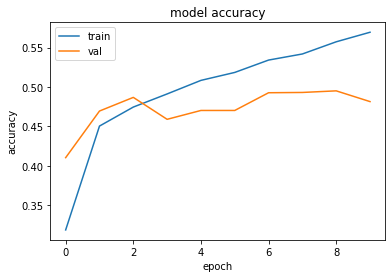

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [ ]:
# EPOCHS = 10

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

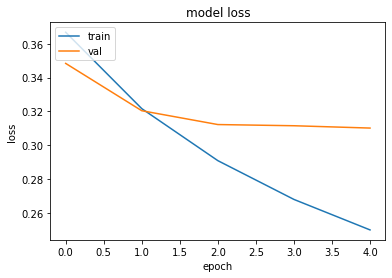

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [ ]:
# EPOCHS = 10

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

**RoBERTa Model prediction on Test Data**

In [ ]:
y_pred_proba = model.predict([test_input_ids,test_attention_masks])

In [ ]:
from sklearn.metrics import jaccard_score
from sklearn.metrics import hamming_loss

# Model evaluation function
def model_eval(y_true, y_pred_labels, emotions):

    # Defining variables
    precision = []
    recall = []
    f1 = []

    # Per emotion evaluation
    idx2emotion = {i: e for i, e in enumerate(emotions)}

    for i in range(len(emotions)):

        # Computing precision, recall and f1-score
        p, r, f1_score, _ = precision_recall_fscore_support(y_true[:, i], y_pred_labels[:, i], average="binary")

        # Append results in lists
        precision.append(round(p, 2))
        recall.append(round(r, 2))
        f1.append(round(f1_score, 2))

    # Macro evaluation
    macro_p, macro_r, macro_f1_score, _ = precision_recall_fscore_support(y_true, y_pred_labels, average="macro")
    # Append results in lists
    precision.append(round(macro_p, 2))
    recall.append(round(macro_r, 2))
    f1.append(round(macro_f1_score, 2))

    precision.append('-')
    recall.append('-')
    f1.append('-')

    precision.append(round(macro_p, 4))
    recall.append(round(macro_r, 4))
    f1.append(round(macro_f1_score, 4))

    # Micro evaluation
    micro_p, micro_r, micro_f1_score, _ = precision_recall_fscore_support(y_true, y_pred_labels, average="micro")
    # Append results in lists
    precision.append(round(micro_p, 4))
    recall.append(round(micro_r, 4))
    f1.append(round(micro_f1_score, 4))



    # jaccard_score evaluation    [None, 'micro', 'macro', 'weighted', 'samples']
    jaccard_micro = jaccard_score(y_true, y_pred_labels, average='micro')
    # Append results in lists
    precision.append('-')
    recall.append(round(jaccard_micro, 4))
    f1.append('-')

    jaccard_macro = jaccard_score(y_true, y_pred_labels, average='macro')
    # Append results in lists
    precision.append('-')
    recall.append(round(jaccard_macro, 4))
    f1.append('-')

    jaccard_weighted = jaccard_score(y_true, y_pred_labels, average='weighted')
    # Append results in lists
    precision.append('-')
    recall.append(round(jaccard_weighted, 4))
    f1.append('-')

    jaccard_samples = jaccard_score(y_true, y_pred_labels, average='samples')
    # Append results in lists
    precision.append('-')
    recall.append(round(jaccard_samples, 4))
    f1.append('-')




    # hamming_loss evaluation
    HL = hamming_loss(y_true, y_pred_labels)
    # Append results in lists
    precision.append('-')
    recall.append(round(HL, 4))
    f1.append('-')


    # Converting results to a dataframe
    df_results = pd.DataFrame({"Precision":precision, "Recall":recall, 'F1':f1})
    df_results.index = emotions+['MACRO-AVERAGE']+['-']+['MACRO-AVERAGE']+['MICRO-AVERAGE']+['jaccard_micro']+['jaccard_macro']+['jaccard_weighted']+['jaccard_samples']+['HL']

    return df_results


In [ ]:
# y_pred_proba = model.predict([test_input_ids,test_attention_masks])

def proba_to_labels_difference_from_mean(y_pred_proba):

    y_pred_labels = np.zeros_like(y_pred_proba)

    for i in range(y_pred_proba.shape[0]):
        mean = statistics.mean(y_pred_proba[i])
        difference_from_mean = np.zeros(y_pred_proba.shape[1])
        for x in range(y_pred_proba.shape[1]):
            difference_from_mean[x] = (y_pred_proba[i][x])**2 - mean**2
        for j in range(y_pred_proba.shape[1]):
            if difference_from_mean[j] > mean*2:
                y_pred_labels[i][j] = 1
            else:
                y_pred_labels[i][j] = 0

    return y_pred_labels

# Generate labels
y_pred_labels = proba_to_labels_difference_from_mean(y_pred_proba)

# Model evaluation
# model_eval(y_test, y_pred_labels, Lable_names)


# sum(np.sum(y_pred_labels, axis=1)==0)




# solution 2 (assign the 'Neutral' emotion)
# Handling empty predictions
y_pred_labels_test_n = np.copy(y_pred_labels)

# if no predictions ==> neutral
for pred in y_pred_labels_test_n:
    if pred.sum()==0:
        pred[-1]=1

# Evaluation
model_eval(y_test, y_pred_labels_test_n, Lable_names)
# sum(np.sum(y_pred_labels_test_n, axis=1)==0)

,Precision,Recall,F1
admiration,0.67,0.61,0.64
amusement,0.76,0.89,0.82
anger,0.36,0.57,0.44
annoyance,0.37,0.18,0.25
approval,0.46,0.32,0.38
caring,0.31,0.63,0.42
confusion,0.35,0.5,0.41
curiosity,0.49,0.69,0.57
desire,0.5,0.51,0.5
disappointment,0.31,0.26,0.28


In [ ]:
# y_pred_proba = model.predict([test_input_ids,test_attention_masks])

def proba_to_labels_difference_from_mean(y_pred_proba):

    y_pred_labels = np.zeros_like(y_pred_proba)

    for i in range(y_pred_proba.shape[0]):
        mean = statistics.mean(y_pred_proba[i])
        difference_from_mean = np.zeros(y_pred_proba.shape[1])
        for x in range(y_pred_proba.shape[1]):
            difference_from_mean[x] = (y_pred_proba[i][x])**2 - mean**2
        for j in range(y_pred_proba.shape[1]):
            if difference_from_mean[j] > mean*2:
                y_pred_labels[i][j] = 1
            else:
                y_pred_labels[i][j] = 0

    return y_pred_labels

# Generate labels
y_pred_labels = proba_to_labels_difference_from_mean(y_pred_proba)



# Model evaluation
# model_eval(y_test, y_pred_labels, Lable_names)


# sum(np.sum(y_pred_labels, axis=1)==0)


# solution 2 (assign the 'Neutral' emotion)
# Handling empty predictions
y_pred_labels_test_n = np.copy(y_pred_labels)

# if no predictions ==> neutral
for pred in y_pred_labels_test_n:
    if pred.sum()==0:
        pred[-1]=1

# Evaluation
model_eval(y_test, y_pred_labels_test_n, Lable_names)
# sum(np.sum(y_pred_labels_test_n, axis=1)==0)

,Precision,Recall,F1
admiration,0.67,0.61,0.64
amusement,0.76,0.89,0.82
anger,0.36,0.57,0.44
annoyance,0.37,0.18,0.25
approval,0.46,0.32,0.38
caring,0.31,0.63,0.42
confusion,0.35,0.5,0.41
curiosity,0.49,0.69,0.57
desire,0.5,0.51,0.5
disappointment,0.31,0.26,0.28


In [ ]:
# y_pred_proba = model.predict([test_input_ids,test_attention_masks])

def proba_to_labels_difference_from_mean(y_pred_proba):

    y_pred_labels = np.zeros_like(y_pred_proba)

    for i in range(y_pred_proba.shape[0]):
        mean = statistics.mean(y_pred_proba[i])
        difference_from_mean = np.zeros(y_pred_proba.shape[1])
        for x in range(y_pred_proba.shape[1]):
            difference_from_mean[x] = (y_pred_proba[i][x])**2 - mean**2
        for j in range(y_pred_proba.shape[1]):
            if difference_from_mean[j] > mean*2:
                y_pred_labels[i][j] = 1
            else:
                y_pred_labels[i][j] = 0

    return y_pred_labels

# Generate labels
y_pred_labels = proba_to_labels_difference_from_mean(y_pred_proba)

# Model evaluation
# model_eval(y_test, y_pred_labels, Lable_names)


# sum(np.sum(y_pred_labels, axis=1)==0)


# solution 2 (assign the 'Neutral' emotion)
# Handling empty predictions
y_pred_labels_test_n = np.copy(y_pred_labels)

# if no predictions ==> neutral
for pred in y_pred_labels_test_n:
    if pred.sum()==0:
        pred[-1]=1

# Evaluation
model_eval(y_test, y_pred_labels_test_n, Lable_names)
# sum(np.sum(y_pred_labels_test_n, axis=1)==0)

,Precision,Recall,F1
admiration,0.67,0.61,0.64
amusement,0.76,0.89,0.82
anger,0.36,0.57,0.44
annoyance,0.37,0.18,0.25
approval,0.46,0.32,0.38
caring,0.31,0.63,0.42
confusion,0.35,0.5,0.41
curiosity,0.49,0.69,0.57
desire,0.5,0.51,0.5
disappointment,0.31,0.26,0.28


In [ ]:
# y_pred_proba = model.predict([test_input_ids,test_attention_masks])

def proba_to_labels_difference_from_mean(y_pred_proba):

    y_pred_labels = np.zeros_like(y_pred_proba)

    for i in range(y_pred_proba.shape[0]):
        mean = statistics.mean(y_pred_proba[i])
        difference_from_mean = np.zeros(y_pred_proba.shape[1])
        for x in range(y_pred_proba.shape[1]):
            difference_from_mean[x] = (y_pred_proba[i][x])**2 - mean**2
        for j in range(y_pred_proba.shape[1]):
            if difference_from_mean[j] > mean*2:
                y_pred_labels[i][j] = 1
            else:
                y_pred_labels[i][j] = 0

    return y_pred_labels

# Generate labels
y_pred_labels = proba_to_labels_difference_from_mean(y_pred_proba)

# Model evaluation
# model_eval(y_test, y_pred_labels, Lable_names)


# sum(np.sum(y_pred_labels, axis=1)==0)


# solution 2 (assign the 'Neutral' emotion)
# Handling empty predictions
y_pred_labels_test_n = np.copy(y_pred_labels)

# if no predictions ==> neutral
for pred in y_pred_labels_test_n:
    if pred.sum()==0:
        pred[-1]=1

# Evaluation
model_eval(y_test, y_pred_labels_test_n, Lable_names)
# sum(np.sum(y_pred_labels_test_n, axis=1)==0)

,Precision,Recall,F1
admiration,0.67,0.61,0.64
amusement,0.76,0.89,0.82
anger,0.36,0.57,0.44
annoyance,0.37,0.18,0.25
approval,0.46,0.32,0.38
caring,0.31,0.63,0.42
confusion,0.35,0.5,0.41
curiosity,0.49,0.69,0.57
desire,0.5,0.51,0.5
disappointment,0.31,0.26,0.28


-------------

In [ ]:
# y_pred_proba = model.predict([test_input_ids,test_attention_masks])

# from probabilities to labels using a given threshold
def proba_to_labels(y_pred_proba, threshold=0.5):

    y_pred_labels = np.zeros_like(y_pred_proba)

    for i in range(y_pred_proba.shape[0]):
        for j in range(y_pred_proba.shape[1]):
            if y_pred_proba[i][j] > threshold:
                y_pred_labels[i][j] = 1
            else:
                y_pred_labels[i][j] = 0

    return y_pred_labels

# Generate labels
y_pred_labels = proba_to_labels(y_pred_proba)

# Model evaluation function
def model_eval(y_true, y_pred_labels, emotions):

    # Defining variables
    precision = []
    recall = []
    f1 = []

    # Per emotion evaluation
    idx2emotion = {i: e for i, e in enumerate(emotions)}

    for i in range(len(emotions)):

        # Computing precision, recall and f1-score
        p, r, f1_score, _ = precision_recall_fscore_support(y_true[:, i], y_pred_labels[:, i], average="binary")

        # Append results in lists
        precision.append(round(p, 2))
        recall.append(round(r, 2))
        f1.append(round(f1_score, 2))

    # Macro evaluation
    macro_p, macro_r, macro_f1_score, _ = precision_recall_fscore_support(y_true, y_pred_labels, average="macro")

    # Append results in lists
    precision.append(round(macro_p, 2))
    recall.append(round(macro_r, 2))
    f1.append(round(macro_f1_score, 2))

    # Converting results to a dataframe
    df_results = pd.DataFrame({"Precision":precision, "Recall":recall, 'F1':f1})
    df_results.index = emotions+['MACRO-AVERAGE']

    return df_results

# Model evaluation
model_eval(y_test, y_pred_labels, Lable_names)

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


,Precision,Recall,F1
admiration,0.82,0.41,0.55
amusement,0.80,0.77,0.78
anger,0.54,0.39,0.46
annoyance,0.00,0.00,0.00
approval,0.73,0.17,0.28
caring,0.44,0.39,0.41
confusion,0.51,0.29,0.37
curiosity,0.52,0.45,0.48
desire,0.58,0.40,0.47
disappointment,0.50,0.07,0.13


In [ ]:
# Function that computes labels from probabilities and optimizes the threshold that maximizes f1-score
def proba_to_labels_opt(y_true, y_pred_proba):

    '''
    Inputs:
        y_true: Ground truth labels
        y_pred_proba: predicted probabilities

    Outputs :
        best_y_pred_labels: preticted labels associated with best threshold
        best_t: best threshold
        best_macro_f1: macro f1-score associated with predicted labels
    '''

    # range of possible thresholds
    thresholds = np.arange(0.1, 0.99, 0.01)

    # Computing threshold that maximizes macro f1-score
    best_y_pred_labels = np.zeros_like(y_pred_proba)
    best_t = 0
    best_macro_f1 = 0

    # Iterating through possible thresholds
    for t in thresholds:

        y_pred_labels = proba_to_labels(y_pred_proba, t)

        _, _, macro_f1, _ = precision_recall_fscore_support(y_true, y_pred_labels, average="macro")

        if macro_f1 > best_macro_f1:
            best_macro_f1 = macro_f1
            best_t = t
            best_y_pred_labels = y_pred_labels

    return best_y_pred_labels, best_t, best_macro_f1

# Compute label predictions and corresponding optimal thresholds
y_pred_labels_opt, threshold_opt, macro_f1_opt = proba_to_labels_opt(y_test, y_pred_proba)
print("The model's threshold is {}".format(threshold_opt))
print("The model's best macro-f1 is {}".format(macro_f1_opt))

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


The model's threshold is 0.24999999999999992
The model's best macro-f1 is 0.4713859409815534


In [ ]:
# Model evaluation
model_eval(y_test, y_pred_labels_opt, Lable_names)

,Precision,Recall,F1
admiration,0.73,0.54,0.62
amusement,0.77,0.89,0.82
anger,0.34,0.57,0.43
annoyance,0.40,0.25,0.31
approval,0.47,0.29,0.36
caring,0.33,0.53,0.41
confusion,0.32,0.54,0.41
curiosity,0.45,0.68,0.54
desire,0.51,0.52,0.51
disappointment,0.34,0.32,0.33


In [ ]:
# Number of predictions with no positive label
sum(np.sum(y_pred_labels_opt, axis=1)==0)

350

In [ ]:
# solution 1 (label with the highest probability)
# Handling empty predictions
y_pred_labels_opt_h = np.copy(y_pred_labels_opt)

# if no predictions ==> label with highest proba
for i, pred in enumerate(y_pred_labels_opt_h):
    if pred.sum()==0:
        pred[np.argmax(y_pred_labels_opt[i])]=1

# Evaluation
model_eval(y_test, y_pred_labels_opt_h, Lable_names)

,Precision,Recall,F1
admiration,0.41,0.59,0.49
amusement,0.77,0.89,0.82
anger,0.34,0.57,0.43
annoyance,0.40,0.25,0.31
approval,0.47,0.29,0.36
caring,0.33,0.53,0.41
confusion,0.32,0.54,0.41
curiosity,0.45,0.68,0.54
desire,0.51,0.52,0.51
disappointment,0.34,0.32,0.33


In [ ]:
# solution 2 (assign the 'Neutral' emotion)
# Handling empty predictions
y_pred_labels_opt_n = np.copy(y_pred_labels_opt)

# if no predictions ==> neutral
for pred in y_pred_labels_opt_n:
    if pred.sum()==0:
        pred[-1]=1

# Evaluation
model_eval(y_test, y_pred_labels_opt_n, Lable_names)

,Precision,Recall,F1
admiration,0.73,0.54,0.62
amusement,0.77,0.89,0.82
anger,0.34,0.57,0.43
annoyance,0.40,0.25,0.31
approval,0.47,0.29,0.36
caring,0.33,0.53,0.41
confusion,0.32,0.54,0.41
curiosity,0.45,0.68,0.54
desire,0.51,0.52,0.51
disappointment,0.34,0.32,0.33


In [ ]:
result = model.predict([test_input_ids,test_attention_masks])
y_pred = np.zeros_like(result)
y_pred[np.arange(len(result)), result.argmax(1)] = 1

**Accuracy and F1 Score of Model**

In [ ]:
from sklearn.metrics import accuracy_score, f1_score
accuracy = accuracy_score(y_test, y_pred)
print('Accuracy ', accuracy)
f1 = f1_score(y_test, y_pred, average = 'macro')
print('F1 Score :', f1)

Accuracy  0.39804914650159445
F1 Score : 0.44020023217880555


In [ ]:
#with unbalance data
from sklearn.metrics import accuracy_score, f1_score
accuracy = accuracy_score(y_test, y_pred)
print('Accuracy ', accuracy)
f1 = f1_score(y_test, y_pred, average = 'macro')
print('F1 Score :', f1)

Accuracy  0.3843129913889929
F1 Score : 0.4100386902032371


In [ ]:
#With a dropout layer
from sklearn.metrics import accuracy_score, f1_score
accuracy = accuracy_score(y_test, y_pred)
print('Accuracy ', accuracy)
f1 = f1_score(y_test, y_pred, average = 'macro')
print('F1 Score :', f1)

Accuracy  0.5426042050903725
F1 Score : 0.3649150698835872


In [ ]:
#With BiLSTM and without Dropout
from sklearn.metrics import accuracy_score, f1_score
accuracy = accuracy_score(y_test, y_pred)
print('Accuracy ', accuracy)
f1 = f1_score(y_test, y_pred, average = 'macro')
print('F1 Score :', f1)

Accuracy  0.5426042050903725
F1 Score : 0.3649150698835872


In [ ]:
#with 100 units GRU and a Flatten layer after
from sklearn.metrics import accuracy_score, f1_score
accuracy = accuracy_score(y_test, y_pred)
print('Accuracy ', accuracy)
f1 = f1_score(y_test, y_pred, average = 'macro')
print('F1 Score :', f1)

Accuracy  0.562
F1 Score : 0.525197133117069


In [ ]:
#with 100 units biLSTM and and a flatten after
from sklearn.metrics import accuracy_score, f1_score
accuracy = accuracy_score(y_test, y_pred)
print('Accuracy ', accuracy)
f1 = f1_score(y_test, y_pred, average = 'macro')
print('F1 Score :', f1)

Accuracy  0.5582857142857143
F1 Score : 0.5314962433635517


In [ ]:
#with an attention layer and a concatenate after 100 units biLSTM and before the dense
from sklearn.metrics import accuracy_score, f1_score
accuracy = accuracy_score(y_test, y_pred)
print('Accuracy ', accuracy)
f1 = f1_score(y_test, y_pred, average = 'macro')
print('F1 Score :', f1)

Accuracy  0.5682857142857143
F1 Score : 0.5367880042686917


In [ ]:
#The Goemotion Data
#without attention layer and with 100 units biLSTM and before the dense
from sklearn.metrics import accuracy_score, f1_score
accuracy = accuracy_score(y_test, y_pred)
print('Accuracy ', accuracy)
f1 = f1_score(y_test, y_pred, average = 'macro')
print('F1 Score :', f1)

Accuracy  0.3878697117184575
F1 Score : 0.414852757566727


In [ ]:
#The Goemotion Data
#with an 10 attention layer and a concatenate after 100 units biLSTM and before the dense with SIGMOID RECURRENT IN LSTM
from sklearn.metrics import accuracy_score, f1_score
accuracy = accuracy_score(y_test, y_pred)
print('Accuracy ', accuracy)
f1 = f1_score(y_test, y_pred, average = 'macro')
print('F1 Score :', f1)

Accuracy  0.39910146012729314
F1 Score : 0.4344495694245672


In [ ]:
#The Goemotion Data
#with an 30 attention layer and a concatenate after 100 units biLSTM and before the dense with SIGMOID RECURRENT IN LSTM with 10 epochs
from sklearn.metrics import accuracy_score, f1_score
accuracy = accuracy_score(y_test, y_pred)
print('Accuracy ', accuracy)
f1 = f1_score(y_test, y_pred, average = 'macro')
print('F1 Score :', f1)

Accuracy  0.42156495694496443
F1 Score : 0.4590584387740383


In [ ]:
#The GoEmotion Data
#with 40 attention layer and a concatenate after 100 units biLSTM and a 0.3 Dropout before the dense
from sklearn.metrics import accuracy_score, f1_score
accuracy = accuracy_score(y_test, y_pred)
print('Accuracy ', accuracy)
f1 = f1_score(y_test, y_pred, average = 'macro')
print('F1 Score :', f1)

Accuracy  0.4141812042768711
F1 Score : 0.4556923688754325


In [ ]:
#The GoEmotion Data
#with 30 attention layer and a concatenate after 100 units biLSTM and before the dense. 6 Epochs without overampling
from sklearn.metrics import accuracy_score, f1_score
accuracy = accuracy_score(y_test, y_pred)
print('Accuracy ', accuracy)
f1 = f1_score(y_test, y_pred, average = 'macro')
print('F1 Score :', f1)

Accuracy  0.38960795347964733
F1 Score : 0.43284507554545637


In [ ]:
# Save the weights
model.save_weights('/content/drive/MyDrive/Colab Notebooks/theSavedWeights/FinalCheckpoints')

# Model Inference

In [ ]:
!pip install emoji
!pip install contractions
# Text processing libraries
import emoji
import re
import contractions
from collections import Counter
import spacy
from spacy.lang.en.stop_words import STOP_WORDS

import nltk
nltk.download('wordnet')
from nltk.stem import WordNetLemmatizer

import spacy
from spacy import displacy
from collections import Counter
import en_core_web_sm

neme_entity = en_core_web_sm.load()

     |████████████████████████████████| 185 kB 12.9 MB/s 
  Created wheel for emoji: filename=emoji-1.5.0-py3-none-any.whl size=187457 sha256=3e846e81a035cd67735eaf827089576ced9b10d60c6e77d95093aaed6b6ef393
  Stored in directory: /root/.cache/pip/wheels/db/b5/f6/b39abf14e94b3d6640613bbe630a66c10ccf7a12882d064fb5
Successfully built emoji
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [ ]:
# Building a preprocessing function to clean text
def preprocess_corpus(x):

  # Adding a space between words and punctation
  x = re.sub( r'([a-zA-Z\[\]])([,;.!?])', r'\1 \2', x)
  x = re.sub( r'([,;.!?])([a-zA-Z\[\]])', r'\1 \2', x)

  # Demojize
  x = emoji.demojize(x)

  # Expand contraction
  x = contractions.fix(x)

  # Lower
  x = x.lower()

  #correct some acronyms/typos/abbreviations
  x = re.sub(r"lmao", "laughing my ass off", x)
  x = re.sub(r"amirite", "am i right", x)
  x = re.sub(r"\b(tho)\b", "though", x)
  x = re.sub(r"\b(ikr)\b", "i know right", x)
  x = re.sub(r"\b(ya|u)\b", "you", x)
  x = re.sub(r"\b(eu)\b", "europe", x)
  x = re.sub(r"\b(da)\b", "the", x)
  x = re.sub(r"\b(dat)\b", "that", x)
  x = re.sub(r"\b(dats)\b", "that is", x)
  x = re.sub(r"\b(cuz)\b", "because", x)
  x = re.sub(r"\b(fkn)\b", "fucking", x)
  x = re.sub(r"\b(tbh)\b", "to be honest", x)
  x = re.sub(r"\b(tbf)\b", "to be fair", x)
  x = re.sub(r"faux pas", "mistake", x)
  x = re.sub(r"\b(btw)\b", "by the way", x)
  x = re.sub(r"\b(bs)\b", "bullshit", x)
  x = re.sub(r"\b(kinda)\b", "kind of", x)
  x = re.sub(r"\b(bruh)\b", "bro", x)
  x = re.sub(r"\b(w/e)\b", "whatever", x)
  x = re.sub(r"\b(w/)\b", "with", x)
  x = re.sub(r"\b(w/o)\b", "without", x)
  x = re.sub(r"\b(doj)\b", "department of justice", x)

  #replace some words with multiple occurences of a letter, example "coooool" turns into --> cool
  x = re.sub(r"\b(j+e{2,}z+e*)\b", "jeez", x)
  x = re.sub(r"\b(co+l+)\b", "cool", x)
  x = re.sub(r"\b(g+o+a+l+)\b", "goal", x)
  x = re.sub(r"\b(s+h+i+t+)\b", "shit", x)
  x = re.sub(r"\b(o+m+g+)\b", "omg", x)
  x = re.sub(r"\b(w+t+f+)\b", "wtf", x)
  x = re.sub(r"\b(w+h+a+t+)\b", "what", x)
  x = re.sub(r"\b(y+e+y+|y+a+y+|y+e+a+h+)\b", "yeah", x)
  x = re.sub(r"\b(w+o+w+)\b", "wow", x)
  x = re.sub(r"\b(w+h+y+)\b", "why", x)
  x = re.sub(r"\b(s+o+)\b", "so", x)
  x = re.sub(r"\b(f)\b", "fuck", x)
  x = re.sub(r"\b(w+h+o+p+s+)\b", "whoops", x)
  x = re.sub(r"\b(ofc)\b", "of course", x)
  x = re.sub(r"\b(the us)\b", "usa", x)
  x = re.sub(r"\b(gf)\b", "girlfriend", x)
  x = re.sub(r"\b(hr)\b", "human ressources", x)
  x = re.sub(r"\b(mh)\b", "mental health", x)
  x = re.sub(r"\b(idk)\b", "i do not know", x)
  x = re.sub(r"\b(gotcha)\b", "i got you", x)
  x = re.sub(r"\b(y+e+p+)\b", "yes", x)
  x = re.sub(r"\b(a*ha+h[ha]*|a*ha +h[ha]*)\b", "haha", x)
  x = re.sub(r"\b(o?l+o+l+[ol]*)\b", "lol", x)
  x = re.sub(r"\b(o*ho+h[ho]*|o*ho +h[ho]*)\b", "ohoh", x)
  x = re.sub(r"\b(o+h+)\b", "oh", x)
  x = re.sub(r"\b(a+h+)\b", "ah", x)
  x = re.sub(r"\b(u+h+)\b", "uh", x)

  # Handling emojis
  x = re.sub(r"<3", " love ", x)
  x = re.sub(r"xd", " smiling_face_with_open_mouth_and_tightly_closed_eyes ", x)
  x = re.sub(r":\)", " smiling_face ", x)
  x = re.sub(r"^_^", " smiling_face ", x)
  x = re.sub(r"\*_\*", " star_struck ", x)
  x = re.sub(r":\(", " frowning_face ", x)
  x = re.sub(r":\^\(", " frowning_face ", x)
  x = re.sub(r";\(", " frowning_face ", x)
  x = re.sub(r":\/",  " confused_face", x)
  x = re.sub(r";\)",  " wink", x)
  x = re.sub(r">__<",  " unamused ", x)
  x = re.sub(r"\b([xo]+x*)\b", " xoxo ", x)
  x = re.sub(r"\b(n+a+h+)\b", "no", x)

  # Handling special cases of text
  x = re.sub(r"h a m b e r d e r s", "hamberders", x)
  x = re.sub(r"b e n", "ben", x)
  x = re.sub(r"s a t i r e", "satire", x)
  x = re.sub(r"y i k e s", "yikes", x)
  x = re.sub(r"s p o i l e r", "spoiler", x)
  x = re.sub(r"thankyou", "thank you", x)
  x = re.sub(r"a^r^o^o^o^o^o^o^o^n^d", "around", x)

  # Remove special characters and numbers replace by space + remove double space
  x = re.sub(r"\b([.]{3,})"," dots ", x)
  x = re.sub(r"[^A-Za-z!?_]+"," ", x)
  x = re.sub(r"\b([s])\b *","", x)
  x = re.sub(r" +"," ", x)

  # name entity
  # neme_entity = en_core_web_sm.load()
  n_e = neme_entity(x)
  n_e = list(map(str, list(n_e.ents)))

  # Lemmatization
  lemmatizer = WordNetLemmatizer()
  filter_words = ['name']
  negative = ['not', 'neither', 'nor', 'but', 'however', 'although', 'nonetheless', 'despite', 'except', 'even though', 'yet']
  stop_words = [z for z in STOP_WORDS if z not in negative]
  preprocessed_tokens = [lemmatizer.lemmatize(temp) for temp in x.split() if temp not in (filter_words + stop_words + n_e)]
  x = ' '.join([pt for pt in preprocessed_tokens]).strip()

  return x

In [ ]:
def roberta_inference_encode(data,maximum_length) :
    input_ids = []
    attention_masks = []

    encoded = tokenizer.encode_plus(
    data,
    add_special_tokens=True,
    max_length=maximum_length,
    pad_to_max_length=True,

    return_attention_mask=True

    )

    input_ids.append(encoded['input_ids'])
    attention_masks.append(encoded['attention_mask'])
    return np.array(input_ids),np.array(attention_masks)

In [ ]:
def predict_samples(text_samples, threshold):

    preprocessed_text = preprocess_corpus(text_samples)
    input_ids, attention_masks = roberta_inference_encode(preprocessed_text, maximum_length = max_len)
    model = create_model(roberta_model, max_len)
    model.load_weights('/content/drive/MyDrive/Colab Notebooks/theSavedWeights/FinalCheckpoints')
    result = model.predict([input_ids, attention_masks])
    darsad = []
    for s in result:
      darsad.append(s)

    # Label prediction using threshold
    samples_pred_labels = proba_to_labels(result)

    # if no predictions ==> neutral
    for pred in samples_pred_labels:
        if pred.sum()==0:
            pred[-1]=1

    return pd.DataFrame(dict(zip( Lable_names , [ x*100 for x in result[0]])).items(), columns = ['Category', '%'])
    # samples_pred_labels_df = pd.DataFrame(samples_pred_labels)
    # samples_pred_labels_df = samples_pred_labels_df.apply(lambda x: [Lable_names[i] for i in range(len(x)) if x[i]==1], axis=1)

    # #return list(samples_pred_labels_df)
    # return pd.DataFrame({"Text":text_samples, "Emotions":list(samples_pred_labels_df)})

In [ ]:
predict_samples("My favourite food is anything I didn't have to cook myself", threshold_opt)

/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2204: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


,Category,%
0,admiration,4.020154
1,amusement,0.531616
2,anger,0.743625
3,annoyance,1.198156
4,approval,7.418519
5,caring,1.019605
6,confusion,3.461461
7,curiosity,0.977627
8,desire,1.231707
9,disappointment,1.357310


In [ ]:
predict_samples("a dog in the park", threshold_opt)

/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2204: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


,Category,%
0,admiration,1.182116
1,amusement,0.836808
2,anger,1.904270
3,annoyance,1.698164
4,approval,3.284207
5,caring,0.505274
6,confusion,0.832113
7,curiosity,0.782153
8,desire,0.976796
9,disappointment,1.024246


In [ ]:
predict_samples("are you kiddin me ??!!", threshold_opt)

/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2204: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


,Category,%
0,admiration,0.628410
1,amusement,1.225294
2,anger,2.950446
3,annoyance,2.261694
4,approval,2.097161
5,caring,0.643231
6,confusion,22.178718
7,curiosity,33.237451
8,desire,0.301342
9,disappointment,1.141976


------------------------------------------------------------

In [ ]:
def plot_result(result):
    sns.barplot(x = 'Category', y = 'Confidence', data = result)
    plt.xlabel('Categories', size=14)
    plt.ylabel('Confidence', size=14)
    plt.title('Emotion Classification', size=16)

In [ ]:
def roberta_inference_encode(data,maximum_length) :
    input_ids = []
    attention_masks = []

    encoded = tokenizer.encode_plus(
    data,
    add_special_tokens=True,
    max_length=maximum_length,
    pad_to_max_length=True,

    return_attention_mask=True

    )

    input_ids.append(encoded['input_ids'])
    attention_masks.append(encoded['attention_mask'])
    return np.array(input_ids),np.array(attention_masks)

In [ ]:
def inference(text_sentence, max_len):
    preprocessed_text = preprocess(text_sentence)
    input_ids, attention_masks = roberta_inference_encode(preprocessed_text, maximum_length = max_len)
    model = create_model(roberta_model, 12)
    model.load_weights('/content/drive/MyDrive/GoEmotion CleanData and Code/theSavedWeights/FinalCheckpoints')
    result = model.predict([input_ids, attention_masks])
    #le.categories_[0] = ['anger' 'fear' 'joy' 'love' 'sadness' 'surprise']
    result = pd.DataFrame(dict(zip(list(le.categories_[0]), [round(x*100, 2)for x in result[0]])).items(), columns = ['Category', 'Confidence'])
    plot_result(result)
    return result

In [ ]:
result = inference("My baby is so annoying", max_len)
print(result)

/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2204: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


NotFoundError: ignored